<a href="https://colab.research.google.com/github/mafeacero/Reconocimiento-emociones-con-Redes-Neuronales/blob/master/3D_ConvNet%20-%20An%C3%A1lisis%20de%20Emociones%20en%20Videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Carga de paquetes

Se cargan todos los paquetes relacionados con las redes neuronales y la carga de los datos desde google. Adicionalmente se cargan los paquetes usuales como son numpy, matplotlib y pues fundamentalmente TensorFlow.

In [1]:
from google.colab import drive #Conexión con Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical


import tensorflow as tf

Using TensorFlow backend.


In [4]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py

# Carga de los datos

Se cargan los datos que ya fueron preprocesados previeamente. Los cuales se encuentran en escalas de gris y con el tamaño de 48x48x44 cada uno. Ya que son 48 pixeles de alto y ancho y 44 frames para cada uno de los videos.

In [5]:
import joblib
x = joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_video/X_speech.joblib')
y = joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_video/y_speech.joblib')
y=y.astype(int)-1

# Definición del Modelo

Se define una red neuronal convolucionada en 3D, la cual tendrá la misma idea de la convolucional usual, pero en este caso se tomará el video como si fuera una imagen en 3D. Las capas que se usan son las usuales como Conv, MaxPool, BatchNormalization, Dense y Dropout.

In [6]:
input_layer = Input((48, 48, 44, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=8, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [7]:
dic  =  {0:'neutral', 1:'calmado', 2:'feliz', 3:'triste', 4:'enojado', 5:'asustado', 6:'disgustado', 7:'sorpresa'}

# Separación de datos en entrenamiento, validación y test

Se separan los datos de forma balanceada para cada grupo, teniendo el mismo número de datos por categoría para cada uno de estos. 

In [ ]:
POR_VAL = 15 #entero
POR_TEST = 5 #entero
seed = 50

ind_train = np.array([])
ind_val = np.array([])
ind_test = np.array([])

for i in list(dic.keys()):

  np.random.seed(seed)
  ind_t = np.array(np.where(y == i)).flatten() #direcciones de esa emoción
  l=len(ind_t)
  
  ind_val_e = np.random.choice(ind_t, int(l // POR_VAL), False) #muestreo
  ind_train_e = np.setdiff1d(ind_t, ind_val_e)
  ind_test_e = np.random.choice(ind_train_e, int(l // POR_TEST), False) #muestreo

  ind_train_e = np.setdiff1d(ind_train_e, ind_test_e)

  ind_train = np.concatenate((ind_train, ind_train_e))
  ind_val = np.concatenate((ind_val, ind_val_e))
  ind_test = np.concatenate((ind_test, ind_test_e))

  seed += 1



In [ ]:
np.random.seed(seed + 1)
ind_train = np.random.choice(ind_train, len(ind_train), False)
ind_val = np.random.choice(ind_val, len(ind_val), False)
ind_test = np.random.choice(ind_test, len(ind_test), False)

In [ ]:
len(ind_test)+len(ind_train)+len(ind_val)


1258

In [ ]:
ind_train=ind_train.astype(int)
ind_val=ind_val.astype(int)
ind_test=ind_test.astype(int)

In [ ]:
X_train=x[ind_train, :,:,:, np.newaxis]
X_val=x[ind_val, :,:,:, np.newaxis]
X_test=x[ind_test, :,:,:, np.newaxis]

In [ ]:
y=to_categorical(y, num_classes=8)

In [ ]:
y_train=y[ind_train]
y_val=y[ind_val]
y_test=y[ind_test]

In [ ]:
[sum(y_test) for x in zip(*y_test)]

[array([16., 33., 33., 33., 33., 33., 33., 33.], dtype=float32),
 array([16., 33., 33., 33., 33., 33., 33., 33.], dtype=float32),
 array([16., 33., 33., 33., 33., 33., 33., 33.], dtype=float32),
 array([16., 33., 33., 33., 33., 33., 33., 33.], dtype=float32),
 array([16., 33., 33., 33., 33., 33., 33., 33.], dtype=float32),
 array([16., 33., 33., 33., 33., 33., 33., 33.], dtype=float32),
 array([16., 33., 33., 33., 33., 33., 33., 33.], dtype=float32),
 array([16., 33., 33., 33., 33., 33., 33., 33.], dtype=float32)]

In [ ]:
import os
save_dir = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/saved_models/'
model_name = 'Emociones_3DCNN_model.{epoch:03d}.h5' 
filepath = os.path.join(save_dir, model_name)

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
      lr*=0.5e3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch >120:
      lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    
    print('Learning rate: ', lr)
    return lr

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

# prepare callbacks for model saving and for learning rate reducer
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-8)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [8]:
model.compile(loss=categorical_crossentropy, optimizer="Adam", metrics=['acc'])

Se define el modelo para correr 100 épocas, por medio de callbacks, se irán guardando los resultados y guardando. 

In [ ]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    validation_data=(X_val, y_val), 
                    batch_size=32, callbacks=callbacks)


Train on 929 samples, validate on 82 samples
Epoch 1/100
Learning rate:  0.001
929/929 [==============================] - 433s 466ms/step - loss: 9.0081 - acc: 0.1421 - val_loss: 73.4139 - val_acc: 0.1220

Epoch 00001: val_acc improved from -inf to 0.12195, saving model to /content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/saved_models/Emociones_3DCNN_model.001.h5
Epoch 2/100
Learning rate:  0.001
929/929 [==============================] - 435s 468ms/step - loss: 2.2454 - acc: 0.2002 - val_loss: 8.1470 - val_acc: 0.1463

Epoch 00002: val_acc improved from 0.12195 to 0.14634, saving model to /content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/saved_models/Emociones_3DCNN_model.002.h5
Epoch 3/100
Learning rate:  0.001
929/929 [==============================] - 432s 465ms/step - loss: 2.0074 - acc: 0.2185 - val_loss: 6.0527 - val_acc: 0.1585

Epoch 00003: val_acc improved from 

In [ ]:
import os
indtrain_name = 'ind_train.joblib'
indtest_name = 'ind_test.joblib'
indval_name='ind_val.joblib'
save_dir = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_video'

savedindtrain = joblib.dump(ind_train, os.path.join(save_dir, indtrain_name))
savedindtest = joblib.dump(ind_test, os.path.join(save_dir, indtest_name))
savedindval = joblib.dump(ind_val, os.path.join(save_dir, indval_name))

In [ ]:
model.load_weights("/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/saved_models/Emociones_3DCNN_model.049.h5")

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

n_row = 1
n_col = 2
fig, ax = plt.subplots(n_row, n_col, sharex = False, sharey = False, figsize=(16,4))


ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(fontsize=12,loc=0)
ax[0].set_title('Training and Validation Accuracy',fontsize=16)
ax[0].set_ylabel('measure',fontsize=14)
ax[0].set_xlabel('epoch', fontsize = 14)
ax[0].set_xlim([1, len(acc)])

ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].legend(fontsize=12)
ax[1].set_title('Training and Validation Loss',fontsize=16)
ax[1].set_ylabel('measure',fontsize=14)
ax[1].set_xlabel('epoch', fontsize = 14)
ax[1].set_xlim([1, len(acc)])


plt.show()

# Predicciones y matriz de confusión


Se carga el mejor modelo obtenido con 68% de val_accuracy. El cual corresponde a la época 49. 

In [9]:
model.load_weights("/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/saved_models/Emociones_3DCNN_model.049.h5")


In [ ]:
X_test1=np.concatenate((X_test, X_val))
y_test1=np.concatenate((y_test, y_val))

In [ ]:
preds = model.evaluate(X_test1, y_test1)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

329/329 [==============================] - 29s 89ms/step
Loss = 2.453942145982412
Test Accuracy = 0.6382978558540344


In [ ]:
from sklearn.metrics import confusion_matrix #matriz de confusión

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
preds = model.predict(X_test1)

In [ ]:
dic  =  {0:'neutral', 1:'calmado', 2:'feliz', 3:'triste', 4:'enojado', 5:'asustado', 6:'disgustado', 7:'sorpresa'}

In [ ]:
l_test=len(y_test1)
y_t = [dic[letter] for letter in y_test1.argmax(1)]

In [ ]:
y_p = []
for i in range(l_test):
  y_p.append(dic[np.where(np.max(preds[i]) == preds[i])[0][0]])

In [ ]:
confusion_matrix(y_t, y_p)

array([[14,  3,  6,  4,  5,  1,  4,  7],
       [ 0, 31,  0,  3,  7,  0,  1,  2],
       [ 2,  1, 34,  2,  4,  0,  0,  1],
       [ 1,  0,  7, 31,  2,  0,  2,  1],
       [ 0,  0,  1,  0, 41,  0,  2,  0],
       [ 1,  4,  0,  1,  1, 14,  0,  0],
       [ 6,  1,  3,  3,  5,  3, 19,  4],
       [ 3,  3,  5,  5,  1,  0,  1, 26]])

In [ ]:
cmat = confusion_matrix(y_t, y_p, labels = list(dic.values()))


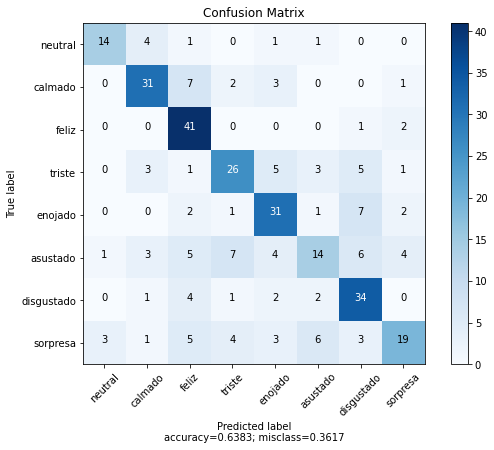

In [ ]:
import matplotlib.pyplot as plt
import itertools    

plot_confusion_matrix(cm = cmat, 
normalize = False,
target_names = list(dic.values()),
title = "Confusion Matrix")

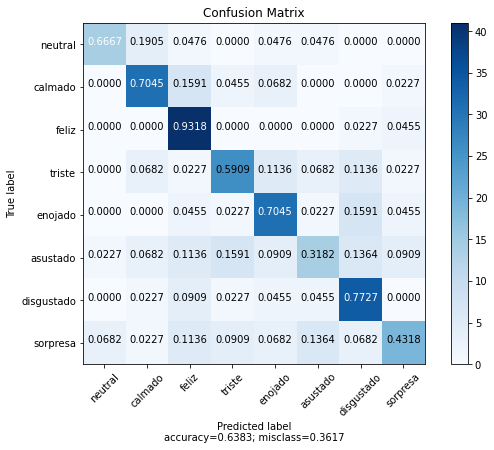

In [ ]:


plot_confusion_matrix(cm = cmat, 
normalize = True,
target_names = list(dic.values()),
title = "Confusion Matrix")